In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
import math
import morfeusz2
np.random.seed(7)

Using TensorFlow backend.


In [ ]:
morf = morfeusz2.Morfeusz(generate=False)

def read_stopwords(file_name):
    tmp = []
    with open(file_name, 'r', encoding='utf-8') as f:
        tmp = f.readlines()
    tmp = [x.strip('\n') for x in tmp]
    return tmp


def remove_words(data):
    for i, line in enumerate(data):
        if i % 1000 == 0:
            print("Step: " + str(i))
        tokenized = word_tokenize(line)
        filtered_line = [w for w in tokenized if w not in stopwords]
        data.loc[i] = ' '.join(filtered_line)
    return data


def lemmatise(data):
    for i, line in enumerate(data):
        if i % 1000 == 0:
            print("Step: " + str(i))
        tokenized = word_tokenize(line)
        lemmatized_line = []
        for word in tokenized:
            analysis = morf.analyse(word)
            w = analysis[0][2][1].split(':')[0]
            lemmatized_line.append(w)
        tmp = ' '.join(lemmatized_line)
        data.loc[i] = ' '.join(lemmatized_line)
    return data

## Functions calculating avarage vectors of words families

In [3]:
def get_synonyms(word):
    synsets = wn.synsets(word)
    synonyms = set([lemma for synset in synsets for lemma in synset.lemma_names()])
    return list(synonyms)


def get_wordfamiliy_average_embeddings(data, mxlen):
    averages = []
    for i, line in enumerate(data):
        line_averages = []
        if i % 1000 == 0:
            print("Step: " + str(i))

        tokenized = word_tokenize(line)    
        for word in tokenized:
            vectors = []
            synonyms = []
            tmp_synonyms = get_synonyms(word)
            
            if len(tmp_synonyms) != 0:
                for synonym in tmp_synonyms:
                    if synonym in word2vec_model:
                        vectors.append(word2vec_model[synonym])
            else:
                if word in word2vec_model:
                    vectors.append(word2vec_model[word])
                continue
            if len(vectors) != 0:
                line_averages.append(np.average(vectors, axis=0))
        
        # padding
        if mxlen - len(line_averages) > 0:
            if np.array(line_averages).shape == (0,):
                tmp = np.zeros(((mxlen - len(line_averages)), 100), dtype=np.float32)
            else:
                tmp = np.concatenate(
                    (np.array(line_averages), np.zeros(((mxlen - len(line_averages)), 100), dtype=np.float32))
                    , axis=0)  
        elif mxlen - len(line_averages) < 0:
            tmp = line_averages[:mxlen]
        
        averages.append(np.array(tmp))
    return np.array(averages)

## Load word2vec model

In [4]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('nkjp.txt', binary=False)

## Read data

In [5]:
dataset = pd.read_csv('preprocessed.csv', delimiter=",")

 
# Delete All NaN values from columns=['description','rate']
dataset = dataset[dataset['description'].notnull()]
dataset = dataset[dataset['rate'].notnull()]
  
# We set all strings as lower case letters
dataset['description'] = dataset['description'].str.lower()

X = dataset['description']
y = dataset['rate']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("X_val shape: " + str(X_val.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))
print("y_val shape: " + str(y_val.shape))

X_train shape: (130701,)
X_test shape: (40845,)
X_val shape: (32676,)
y_train shape: (130701,)
y_test shape: (40845,)
y_val shape: (32676,)


## Prepare data - from text to avarage embedding vectors of words families 

In [6]:
mxlen = 50
nb_classes = 3

In [ ]:
X_train1 = replace_with_synonyms(X_train, mxlen)
X_test1 = replace_with_synonyms(X_test, mxlen)
X_val1 = replace_with_synonyms(X_val, mxlen)

## Or load preprocessed

In [7]:
X_train1 = np.load('X_train.npy')
X_test1 = np.load('X_test.npy')
X_val1 = np.load('X_val.npy')

In [8]:

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

In [9]:
print(X_train1.shape)

(130701, 50, 100)


## Create model

In [10]:
batch_size = 32
nb_epoch = 6


In [11]:
model = Sequential()
model.add(LSTM(128, input_shape=(mxlen, 100, ), recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Train

In [12]:
rnn = model.fit(X_train1, y_train, nb_epoch= nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val1, y_val))
score = model.evaluate(X_val1, y_val)
model.summary()
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

C:\Users\Jakub\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 130701 samples, validate on 32676 samples
Epoch 1/6
130701/130701 [==============================] - 250s 2ms/step - loss: 0.1071 - accuracy: 0.9798 - val_loss: 0.0727 - val_accuracy: 0.9796
Epoch 2/6
130701/130701 [==============================] - 252s 2ms/step - loss: 0.0713 - accuracy: 0.9801 - val_loss: 0.0656 - val_accuracy: 0.9797
Epoch 3/6
130701/130701 [==============================] - 250s 2ms/step - loss: 0.0673 - accuracy: 0.9802 - val_loss: 0.0630 - val_accuracy: 0.9800
Epoch 4/6
130701/130701 [==============================] - 228s 2ms/step - loss: 0.0660 - accuracy: 0.9801 - val_loss: 0.0615 - val_accuracy: 0.9800
Epoch 5/6
130701/130701 [==============================] - 223s 2ms/step - loss: 0.0678 - accuracy: 0.9805 - val_loss: 0.0632 - val_accuracy: 0.9801
Epoch 6/6
32676/32676 [==============================] - 16s 479us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape   

## Save model

In [13]:
print('Save model...')
model.save('Models/woEmbeddinglayerModel.h5')
print('Saved model to disk...')
 
# print('Save Word index...')
# output = open('Models/finalwordindexhomemade.pkl', 'wb')
# pickle.dump(word_index, output)
# print('Saved word index to disk...')

Save model...
Saved model to disk...


## Plots

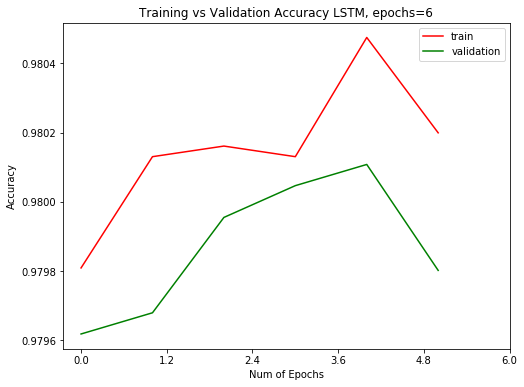

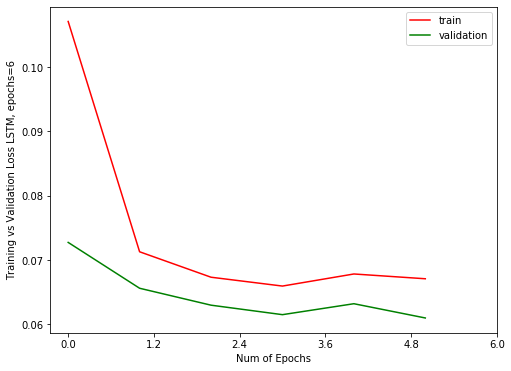

In [21]:
plt.figure(0)
plt.plot(rnn.history['accuracy'],'r')
plt.plot(rnn.history['val_accuracy'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy LSTM, epochs=6") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])
 
plt.figure(1)
plt.plot(rnn.history['loss'],'r')
plt.plot(rnn.history['val_loss'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Training vs Validation Loss LSTM, epochs=6") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])
plt.show()

In [16]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
 
y_pred = model.predict(X_test1)
 
# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_test]

yy_scores = [np.argmax(i) for i in y_pred]
 
print("Recall: " + str(recall_score(yy_true, yy_scores, average='weighted')))
print("Precision: " + str(precision_score(yy_true, yy_scores, average='weighted')))
print("F1 Score: " + str(f1_score(yy_true, yy_scores, average='weighted')))

Recall: 0.9803892765332354
Precision: 0.966407265320268
F1 Score: 0.9713020023417648


C:\Users\Jakub\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Jakub\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
from keras.models import load_model

model = load_model('./Models/woEmbeddinglayerModel.h5')
model.summary()
score = model.evaluate(X_test1, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 117,635
Trainable params: 117,635
Non-trainable params: 0
_________________________________________________________________
accuracy: 98.04%
